In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from scipy.cluster.hierarchy import dendrogram, linkage
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from itertools import combinations 

In [6]:
# Load the pretrained model
model = models.googlenet(pretrained=True)
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

In [7]:
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [67]:
# get features
def get_features(path1):
    path = '/Users/audreychu/Documents/NYU/1016 Computational Cognitive Modeling/CCM_SimilarityRatings/Selected Bird Images/'
    input_image = Image.open(path+path1)
    
    # resize and preprocess image
    from torchvision import transforms
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # creating minibatch for model
    
    features = model(input_batch)
    
    return features

In [68]:
images = ["bl1", "bl2", "bl3","hw1","hw2", "hw3", "ib1","ib2", "ib3","mw1", "mw2", "mw3", "pb1", "pb2", "pb3", "sc1", "sc2", "sc3"]
images1 = ['Bobolark','Bobolark','Bobolark'
          ,'Hooded Warbler','Hooded Warbler','Hooded Warbler'
          ,'Indigo Bunting','Indigo Bunting','Indigo Bunting'
          ,'Marsh Wren','Marsh Wren','Marsh Wren'
          ,'Painted Bunting','Painted Bunting','Painted Bunting'
          ,'Shiny Cowbird','Shiny Cowbird','Shiny Cowbird']

path = '/Users/audreychu/Documents/NYU/1016 Computational Cognitive Modeling/CCM_SimilarityRatings/Selected Bird Images/'

gnet = {}
for i in range(len(images)):
    feature = get_features(images[i]+'.jpg')
    gnet.update({images[i] : feature})

In [69]:
li = []

for i in range(len(images)):
    li.append(gnet[images[i]].cpu().detach().numpy())
    
F = np.array(li)
F = np.reshape(F, (18,1000))

print(F)

[[-0.59991395 -1.0335497  -1.0159639  ... -0.43194714 -0.7737956
   0.9148326 ]
 [ 0.27822354 -0.7334003  -0.8921447  ... -1.105648   -0.3129541
   0.50221825]
 [-0.7516241  -1.3029852  -1.1998289  ... -0.807727    0.13330117
   0.05969378]
 ...
 [-0.19553187 -0.50044286 -0.52340055 ... -1.0676931   0.76508605
  -0.02152187]
 [-0.31019595 -1.1189066  -0.6698488  ... -0.870679    0.02597281
  -0.02501833]
 [-0.19554871 -0.5590801  -1.2987195  ...  0.21187785  1.4316801
  -1.3223212 ]]


In [70]:
OrigSimMat = F.dot(F.transpose())
#OrigSimMat = np.reshape(OrigSimMat, (324))
print(OrigSimMat)

[[ 853.0809    480.25925   504.84988   136.88745   239.8763    155.72443
   144.82925   166.46017   175.82582   208.35796   231.59601   282.206
    61.461796   67.09781   163.9015    607.82056   550.2084    502.1165  ]
 [ 480.25925   651.4821    466.808     149.20789   269.02957   240.53479
   137.5536    222.53062   149.3454    245.08745   293.9646    325.3362
   114.82583   107.36152   156.1136    407.71338   354.6505    318.7319  ]
 [ 504.84988   466.808     950.85693   316.13965   295.4729    221.05539
   343.63232   210.85915   212.5311    466.77084   399.36426   393.91864
   253.1323    176.25423   268.95627   386.659     572.32214   456.61887 ]
 [ 136.88745   149.20789   316.13965   899.9364    412.34326   330.79074
   237.73317   167.9011    120.73614   286.9267    195.27078   120.94491
   201.1157    112.3367    287.56107    43.27485   117.96313    35.37794 ]
 [ 239.8763    269.02957   295.4729    412.34326   643.40515   439.39844
    33.668804  182.92159    99.7297    230.122

In [71]:
# Googlenet has 1000 features
F.shape

(18, 1000)

In [72]:
OrigSimMat = F.dot(F.transpose())
OrigSimMat.shape

(18, 18)

In [74]:
# flattened for rescaling
flat_fft = OrigSimMat.reshape(1,324)

In [75]:
def scale(col, min=1, max=6):
    range = col.max() - col.min()
    a = (col - col.min()) / range
    return a * (max - min) + min

In [77]:
scaled_fft = scale(flat_fft)

In [79]:
final_fft = scaled_fft.reshape(18,18)

In [80]:
ind = [(0, 2),
 (0, 3),
 (12, 4),
 (3, 4),
 (3, 5),
 (6, 7),
 (6, 9),
 (17, 2),
 (7, 14),
 (17, 4)]

In [84]:
comparison = []
for i in ind:
    comparison.append(final_fft[i])

In [85]:
comparison

[2.8203223,
 1.5425591,
 1.5351628,
 2.4990897,
 2.2158954,
 3.391043,
 2.3249764,
 2.6528382,
 2.8747349,
 1.4833697]

In [429]:
rep1 = np.array(OrigSimMat)

In [430]:
names = ['bobolark'
 , 'hooded warbler'
 , 'indigo bunting'
 , 'marsh wren'
 , 'painted bunting'
 , 'shiny cowbird']

### Plot Dendrogram

In [431]:
def plot_dendo(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2],linked2[:,2],linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(7,12))
    plt.subplot(3,1,1)    
    names = list(names)
    dendrogram(linked1, labels = names, color_threshold=0)
    plt.ylim([0,mx])
    plt.title('Hierarchical clustering; ' + "epoch ")
    plt.ylabel('Euclidean distance')
    plt.subplot(3,1,2)
    plt.title("epoch ")
    dendrogram(linked2, labels = names, color_threshold=0)
    plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch ")
    dendrogram(linked3, labels = names, color_threshold=0)
    plt.ylim([0,mx])
    plt.show()

In [436]:
# human data
human_rep = human_sim(human_mat)
linked1 = linkage(human_rep)

# deep data
linked2 = linkage(OrigSimMat)

# adapted data
linked3 = linkage(fwf_t)

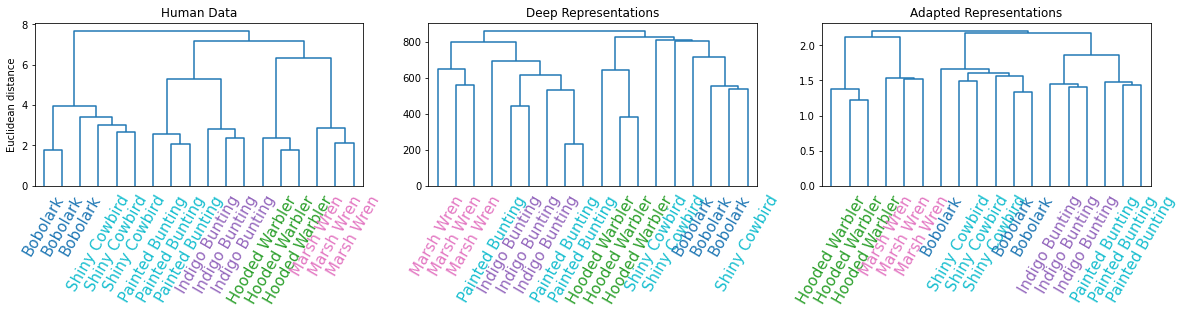

In [441]:


#mx = np.dstack((linked1[:,2],linked2[:,2],linked3[:,2])).max()+0.1    
plt.figure(2,figsize=(20,3))

plt.subplot(1,3,1)    
names = list(names)
dendrogram(linked1, labels = images1, leaf_rotation=60, color_threshold=0,leaf_font_size=15)
#plt.ylim([0,mx])
my_palette = plt.cm.get_cmap("tab10", 6)
images_color=pd.Categorical(images1)
my_color=images_color.codes
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for l in xlbls:
    if l.get_text() == 'Bobolark':
        l.set_color(my_palette(0))
    elif l.get_text() == 'Hooded Warbler':
        l.set_color(my_palette(1))
    elif l.get_text() == 'Indigo Bunting':
        l.set_color(my_palette(2))
    elif l.get_text() == 'Marsh Wren':
        l.set_color(my_palette(3))
    elif l.get_text() == 'Painting Bunting':
        l.set_color(my_palette(4))
    else:
        l.set_color(my_palette(5))
plt.title('Human Data')
plt.ylabel('Euclidean distance')

plt.subplot(1,3,2)
plt.title("Deep Representations")
dendrogram(linked2, labels = images1, leaf_rotation=60, color_threshold=0, leaf_font_size=15)
#plt.ylim([0,mx])
my_palette = plt.cm.get_cmap("tab10", 6)
images_color=pd.Categorical(images1)
my_color=images_color.codes
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for l in xlbls:
    if l.get_text() == 'Bobolark':
        l.set_color(my_palette(0))
    elif l.get_text() == 'Hooded Warbler':
        l.set_color(my_palette(1))
    elif l.get_text() == 'Indigo Bunting':
        l.set_color(my_palette(2))
    elif l.get_text() == 'Marsh Wren':
        l.set_color(my_palette(3))
    elif l.get_text() == 'Painting Bunting':
        l.set_color(my_palette(4))
    else:
        l.set_color(my_palette(5))

plt.subplot(1,3,3)
plt.title("Adapted Representations")
dendrogram(linked3, labels = images1, leaf_rotation=60, color_threshold=0,leaf_font_size=15)
#plt.ylim([0,mx])
my_palette = plt.cm.get_cmap("tab10", 6)
images_color=pd.Categorical(images1)
my_color=images_color.codes
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for l in xlbls:
    if l.get_text() == 'Bobolark':
        l.set_color(my_palette(0))
    elif l.get_text() == 'Hooded Warbler':
        l.set_color(my_palette(1))
    elif l.get_text() == 'Indigo Bunting':
        l.set_color(my_palette(2))
    elif l.get_text() == 'Marsh Wren':
        l.set_color(my_palette(3))
    elif l.get_text() == 'Painting Bunting':
        l.set_color(my_palette(4))
    else:
        l.set_color(my_palette(5))

plt.show()


In [ ]:
# Human matrix

In [434]:
# Human matrix

def human_sim(human_mat):
    hum_sim_surv = pd.read_csv(human_mat,header=None)
    hum_avg_ratings = hum_sim_surv.loc[0].to_numpy()
    
    hum_sim_mat = np.zeros((18,18))
    ind = 0
    hum_sim_mat[:] = np.nan
    for i in range(18):
        for j in range(i,18):
            if i!=j:
                hum_sim_mat[i,j] = hum_avg_ratings[ind]
                hum_sim_mat[j,i] = hum_avg_ratings[ind]
                ind+=1
            else:
                hum_sim_mat[i,j] = 6
    #hum_sim_mat_corr = np.reshape(hum_sim_mat,(18*18))
    return hum_sim_mat

In [59]:
human_mat = 'caffe_net/avg_hum_ratings.csv'

In [93]:
human_rep = human_sim(human_mat)
linked2 = linkage(human_rep)

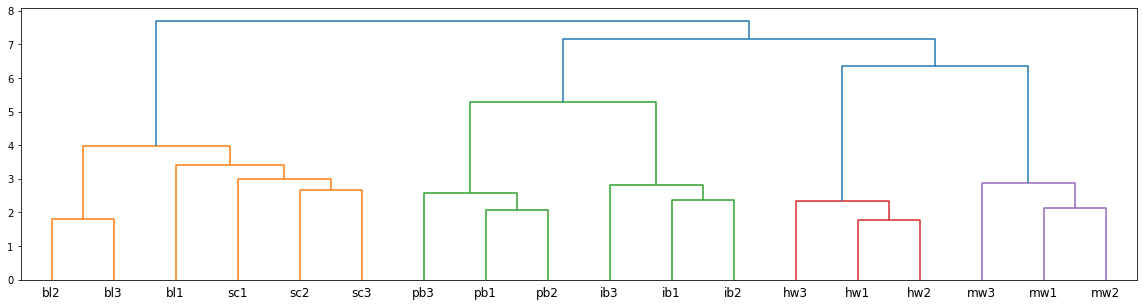

In [98]:
plt.figure(figsize=(20,5))
dendrogram(linked2,labels = images, color_threshold=)
plt.show()

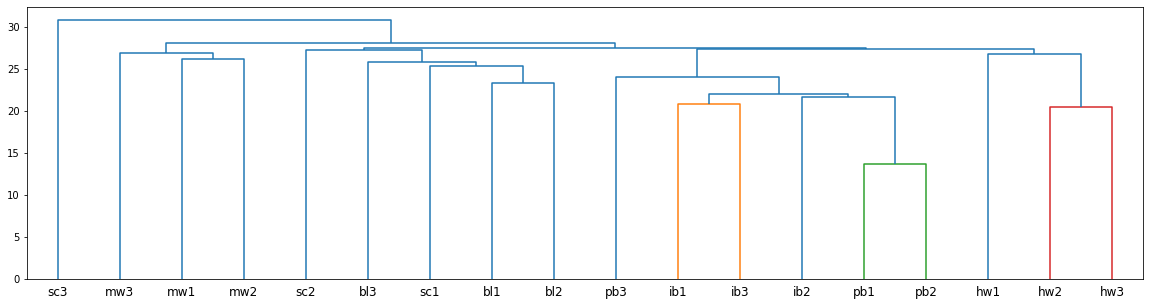

In [102]:
plt.figure(figsize=(20,5))
dendrogram(linkage(F),labels = images)
plt.show()

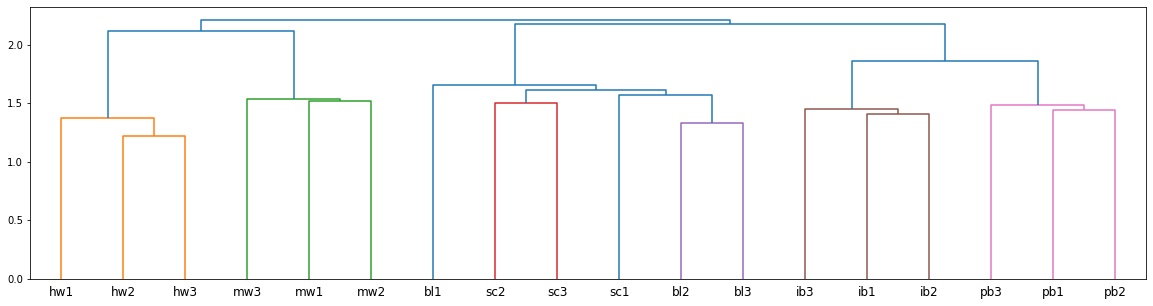

In [272]:
plt.figure(figsize=(20,5))
dendrogram(linkage(fwf_t),labels = images)
plt.show()

### Multi Dimensional Scaling (MDS)

In [23]:
# Multi Dimensional Scaling (MDS)
import numpy as np
import scipy
import matplotlib.pyplot as plt

# jaccard diss.
#from sklearn.metrics import pairwise_distance
# multidim scaling
from sklearn import manifold

In [216]:
# define image plot function

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

paths = [i + '.jpg' for i in images]

In [207]:
def getImage(path, new_size):
    # return OffsetImage(plt.imread(path))
    path1 = '/Users/audreychu/Documents/NYU/1016 Computational Cognitive Modeling/CCM_SimilarityRatings/Selected Bird Images/'
    
    img = Image.open(path1+path)
    img.thumbnail((new_size, new_size), Image.BILINEAR)  # resizes image in-place

    return OffsetImage(img)

In [60]:
# get FWF^T
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate

def fwf(model,human_mat):
    hum_sim_surv = pd.read_csv(human_mat,header=None)
    hum_avg_ratings = hum_sim_surv.loc[0].to_numpy()
    
    hum_sim_mat = np.zeros((18,18))
    ind = 0
    hum_sim_mat[:] = np.nan
    for i in range(18):
        for j in range(i,18):
            if i!=j:
                hum_sim_mat[i,j] = hum_avg_ratings[ind]
                hum_sim_mat[j,i] = hum_avg_ratings[ind]
                ind+=1
            else:
                hum_sim_mat[i,j] = 6
    hum_sim_mat_corr = np.reshape(hum_sim_mat,(18*18))
    F =np.genfromtxt(model,delimiter=',')
    #F = np.reshape(F, (18,4096))
    
    model_sim = np.dot(F,np.transpose(F))
    model_sim_corr =  np.reshape(model_sim, (18*18))
    
    deep_corr = (np.corrcoef(hum_sim_mat_corr,model_sim_corr)[0,1])**2
    
    hum_sim_i_j = []
    for i in range(hum_sim_mat.shape[0]):
        for j in range(i,hum_sim_mat.shape[1]):
            hum_sim_i_j.append(hum_sim_mat[i,j])
            
    model_F= []
    for i in range(F.shape[0]):
        for j in range(i,F.shape[0]):
            model_F.append(F[i] * F[j])
            
    model_F_cv= []
    for i in range(F.shape[0]):
        for j in range(F.shape[0]):
            model_F_cv.append(F[i] * F[j])    
    
    reg = Ridge(solver='sag', fit_intercept=False)
    parameters = {'alpha': [10,100,1000,1e4, 50000, 1e5,1e6]}
    search = GridSearchCV(reg, parameters, scoring='neg_mean_squared_error', cv=6)
    search.fit(model_F, hum_sim_i_j)
    
    best_reg = search.best_estimator_
    #print(best_reg)
    
    
    a=cross_validate(best_reg,model_F_cv,hum_sim_mat_corr,scoring="r2",cv=6)
    
    PredSimMat = best_reg.predict(model_F_cv)
    
    return PredSimMat.reshape(18,18)

In [61]:
fwf_t = fwf('googlenet_mat.csv',human_mat)

In [62]:
fwf_t.shape

(18, 18)

In [63]:
fwf_t

array([[5.6015809 , 3.04585865, 2.81766292, 1.49402033, 1.90581448,
        2.22926107, 2.01084977, 1.79739603, 2.05187828, 2.19539661,
        2.09966596, 1.75900802, 2.03372589, 1.86781537, 1.61218702,
        2.90533871, 3.05029754, 3.16335737],
       [3.04585865, 5.79159759, 3.8313355 , 1.90283321, 2.27451396,
        2.13911351, 2.09058772, 2.1250422 , 1.92244528, 2.327154  ,
        2.71005266, 2.04286534, 2.09574182, 1.97562704, 2.0072058 ,
        3.33119221, 3.00159813, 3.19261534],
       [2.81766292, 3.8313355 , 5.92217212, 1.59799078, 1.98333162,
        1.85515546, 2.21810361, 1.83985169, 1.96937277, 2.25635677,
        1.94966619, 1.92848173, 1.69945974, 1.40270126, 1.5013387 ,
        2.62500533, 3.12075167, 3.37655137],
       [1.49402033, 1.90283321, 1.59799078, 6.16700054, 3.87020264,
        3.59429475, 2.14131202, 2.27451755, 1.95867913, 2.47032193,
        2.40381618, 2.12179202, 2.24349956, 2.21806702, 1.94545534,
        1.99076884, 2.04988643, 1.55535641],
    

In [246]:
def scale(col, min, max):
    range = col.max() - col.min()
    a = (col - col.min()) / range
    return a * (max - min) + min

In [250]:
human_rep = scale(human_rep, -1, 1)
OrigSimMat = scale(OrigSimMat, -1, 1)
fwf_t = scale(fwf_t, -1, 1)

In [251]:
# plot similarity for human data
mds_model = manifold.MDS(n_components=2, dissimilarity = 'euclidean')

# human fit
mds_fit_human = mds_model.fit(human_rep)
mds_coords_human = mds_model.fit_transform(human_rep)
x_human = mds_coords_human[:,0]
y_human = mds_coords_human[:,1]

# deep fit
mds_fit_deep = mds_model.fit(OrigSimMat)
mds_coords_deep = mds_model.fit_transform(OrigSimMat)
x_deep = mds_coords_deep[:,0]
y_deep = mds_coords_deep[:,1]

# adapted fit
mds_fit_adap = mds_model.fit(fwf_t)
mds_coords_adap = mds_model.fit_transform(fwf_t)
x_adap = mds_coords_adap[:,0]
y_adap = mds_coords_adap[:,1]

/Users/audreychu/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/Users/audreychu/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/Users/audreychu/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/Users/audrey

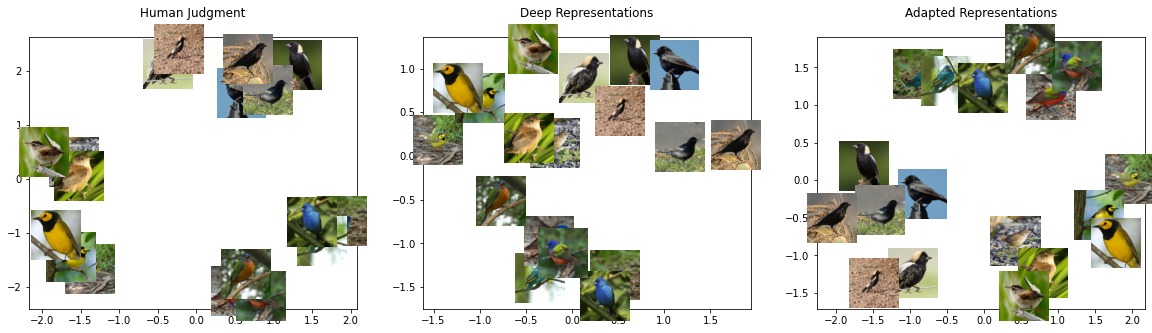

In [271]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3)

ax1.scatter(x_human, y_human)
for x0, y0, path in zip(x_human, y_human,paths):
    ab = AnnotationBbox(getImage(path, new_size = 50), (x0, y0), frameon=False)
    ax1.add_artist(ab)
    
ax2.scatter(x_deep, y_deep)
for x0, y0, path in zip(x_deep, y_deep,paths):
    ab = AnnotationBbox(getImage(path, new_size = 50), (x0, y0), frameon=False)
    ax2.add_artist(ab)
    
ax3.scatter(x_adap, y_adap)
for x0, y0, path in zip(x_adap, y_adap,paths):
    ab = AnnotationBbox(getImage(path, new_size = 50), (x0, y0), frameon=False)
    ax3.add_artist(ab)
    
ax1.set_title('Human Judgment',pad=20)
ax2.set_title('Deep Representations',pad=20)
ax3.set_title('Adapted Representations',pad=20)
    
fig.set_size_inches(20, 5, forward=True)

### Get Sample Image Pairs

In [10]:
path

'/Users/audreychu/Documents/NYU/1016 Computational Cognitive Modeling/CCM_SimilarityRatings/Selected Bird Images/'

In [13]:
images = ["bl1", "bl2", "bl3","hw1","hw2", "hw3", "ib1","ib2", "ib3","mw1", "mw2", "mw3", "pb1", "pb2", "pb3", "sc1", "sc2", "sc3"]
combos = list(combinations(images, 2)) #all the combinations, n choose 2

combos

[('bl1', 'bl2'),
 ('bl1', 'bl3'),
 ('bl1', 'hw1'),
 ('bl1', 'hw2'),
 ('bl1', 'hw3'),
 ('bl1', 'ib1'),
 ('bl1', 'ib2'),
 ('bl1', 'ib3'),
 ('bl1', 'mw1'),
 ('bl1', 'mw2'),
 ('bl1', 'mw3'),
 ('bl1', 'pb1'),
 ('bl1', 'pb2'),
 ('bl1', 'pb3'),
 ('bl1', 'sc1'),
 ('bl1', 'sc2'),
 ('bl1', 'sc3'),
 ('bl2', 'bl3'),
 ('bl2', 'hw1'),
 ('bl2', 'hw2'),
 ('bl2', 'hw3'),
 ('bl2', 'ib1'),
 ('bl2', 'ib2'),
 ('bl2', 'ib3'),
 ('bl2', 'mw1'),
 ('bl2', 'mw2'),
 ('bl2', 'mw3'),
 ('bl2', 'pb1'),
 ('bl2', 'pb2'),
 ('bl2', 'pb3'),
 ('bl2', 'sc1'),
 ('bl2', 'sc2'),
 ('bl2', 'sc3'),
 ('bl3', 'hw1'),
 ('bl3', 'hw2'),
 ('bl3', 'hw3'),
 ('bl3', 'ib1'),
 ('bl3', 'ib2'),
 ('bl3', 'ib3'),
 ('bl3', 'mw1'),
 ('bl3', 'mw2'),
 ('bl3', 'mw3'),
 ('bl3', 'pb1'),
 ('bl3', 'pb2'),
 ('bl3', 'pb3'),
 ('bl3', 'sc1'),
 ('bl3', 'sc2'),
 ('bl3', 'sc3'),
 ('hw1', 'hw2'),
 ('hw1', 'hw3'),
 ('hw1', 'ib1'),
 ('hw1', 'ib2'),
 ('hw1', 'ib3'),
 ('hw1', 'mw1'),
 ('hw1', 'mw2'),
 ('hw1', 'mw3'),
 ('hw1', 'pb1'),
 ('hw1', 'pb2'),
 ('hw1', 'pb3'

In [14]:
for i in range(0,len(combos)):
    img_a = combos[i][0]+".jpg"
    img_b = combos[i][1]+".jpg"
    print(img_a,img_b)

bl1.jpg bl2.jpg
bl1.jpg bl3.jpg
bl1.jpg hw1.jpg
bl1.jpg hw2.jpg
bl1.jpg hw3.jpg
bl1.jpg ib1.jpg
bl1.jpg ib2.jpg
bl1.jpg ib3.jpg
bl1.jpg mw1.jpg
bl1.jpg mw2.jpg
bl1.jpg mw3.jpg
bl1.jpg pb1.jpg
bl1.jpg pb2.jpg
bl1.jpg pb3.jpg
bl1.jpg sc1.jpg
bl1.jpg sc2.jpg
bl1.jpg sc3.jpg
bl2.jpg bl3.jpg
bl2.jpg hw1.jpg
bl2.jpg hw2.jpg
bl2.jpg hw3.jpg
bl2.jpg ib1.jpg
bl2.jpg ib2.jpg
bl2.jpg ib3.jpg
bl2.jpg mw1.jpg
bl2.jpg mw2.jpg
bl2.jpg mw3.jpg
bl2.jpg pb1.jpg
bl2.jpg pb2.jpg
bl2.jpg pb3.jpg
bl2.jpg sc1.jpg
bl2.jpg sc2.jpg
bl2.jpg sc3.jpg
bl3.jpg hw1.jpg
bl3.jpg hw2.jpg
bl3.jpg hw3.jpg
bl3.jpg ib1.jpg
bl3.jpg ib2.jpg
bl3.jpg ib3.jpg
bl3.jpg mw1.jpg
bl3.jpg mw2.jpg
bl3.jpg mw3.jpg
bl3.jpg pb1.jpg
bl3.jpg pb2.jpg
bl3.jpg pb3.jpg
bl3.jpg sc1.jpg
bl3.jpg sc2.jpg
bl3.jpg sc3.jpg
hw1.jpg hw2.jpg
hw1.jpg hw3.jpg
hw1.jpg ib1.jpg
hw1.jpg ib2.jpg
hw1.jpg ib3.jpg
hw1.jpg mw1.jpg
hw1.jpg mw2.jpg
hw1.jpg mw3.jpg
hw1.jpg pb1.jpg
hw1.jpg pb2.jpg
hw1.jpg pb3.jpg
hw1.jpg sc1.jpg
hw1.jpg sc2.jpg
hw1.jpg sc3.jpg
hw2.jpg 

In [ ]:
def getImage(path, new_size):
    # return OffsetImage(plt.imread(path))
    path1 = '/Users/audreychu/Documents/NYU/1016 Computational Cognitive Modeling/CCM_SimilarityRatings/Selected Bird Images/'
    
    img = Image.open(path1+path)
    img.thumbnail((new_size, new_size), Image.BILINEAR)  # resizes image in-place

    return OffsetImage(img)

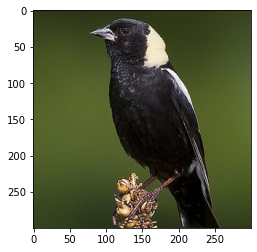

In [24]:
img = Image.open(path+combos[0][0]+'.jpg')

plt.imshow(img)

In [ ]:
fo

NameError: name 'ax' is not defined

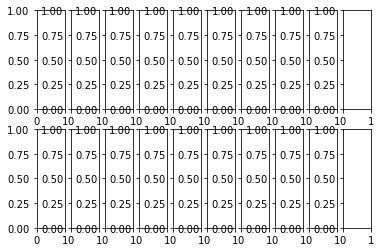

In [38]:
# show first 10 pairs

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10),
     (ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20)) = plt.subplots(nrows=2, ncols=10)


for i in range(10):
    img1 = Image.open(path+combos[i][0]+'.jpg')
    img2 = Image.open(path+combos[i][1]+'.jpg')
    
    ax[i].imshow(img1)
    ax[i].axis('off')
    ax[i+10].imshow(img2)
    ax[i+10].axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
    

In [45]:
len(images)

18

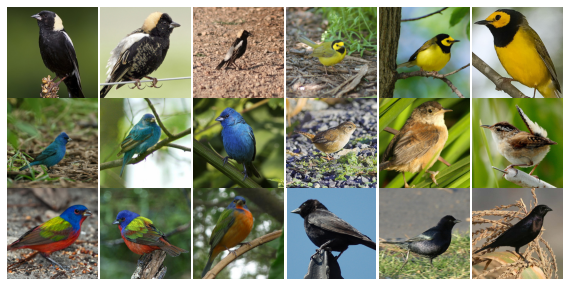

In [55]:
w=10
h=10
fig=plt.figure(figsize=(10, 5))
columns = 6
rows = 3
for i in range(1, columns*rows+1):
    #img = np.random.randint(10, size=(h,w))
    img = Image.open(path+images[i-1]+'.jpg')
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [86]:
pairs = (('bl1', 'bl3'),
 ('bl1', 'hw1'),
 ('pb1', 'hw2'),
 ('hw1', 'hw2'),
 ('hw1', 'hw3'),
 ('ib1', 'ib2'),
 ('ib1', 'mw1'),
 ('sc3', 'bl3'),
 ('ib2', 'pb3'),
 ('sc3', 'hw2'))

In [89]:
pairs[0][0]

'bl1'

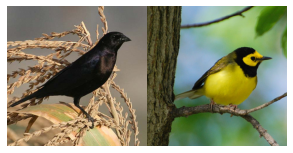

In [108]:
fig=plt.figure(figsize=(5, 30))
columns = 2
rows = 1
sub = 1
for i in range(10, 11):
    #img = np.random.randint(10, size=(h,w))
    img = Image.open(path+pairs[i-1][0]+'.jpg')
    fig.add_subplot(rows, columns, sub)
    plt.imshow(img)
    sub=sub+1
    plt.axis('off')

    img2= Image.open(path+pairs[i-1][1]+'.jpg')
    fig.add_subplot(rows, columns, sub)
    plt.imshow(img2)
    sub+=1
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

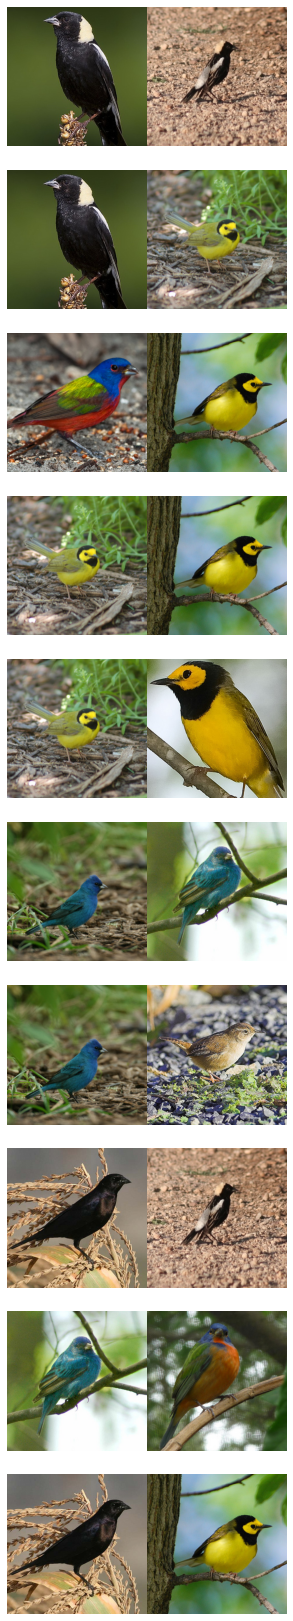

In [98]:
fig=plt.figure(figsize=(5, 30))
columns = 2
rows = 10
sub = 1
for i in range(1, 11):
    #img = np.random.randint(10, size=(h,w))
    img = Image.open(path+pairs[i-1][0]+'.jpg')
    fig.add_subplot(rows, columns, sub)
    plt.imshow(img)
    sub=sub+1
    plt.axis('off')

    img2= Image.open(path+pairs[i-1][1]+'.jpg')
    fig.add_subplot(rows, columns, sub)
    plt.imshow(img2)
    sub+=1
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()